## 1.1. Using Kaggle GPU for Training


In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

In [6]:
!pip install transformers

Download the training dataset using gdown

In [7]:
import pandas as pd

# Load the dataset into a pandas dataframe.
# df = pd.read_csv("small_snli_train.tsv", sep='\t', header=None, names=['gold_label','sentence1','sentence2'])
train_df = pd.read_csv("/kaggle/input/snli-datasets/small_snli_train.tsv", sep='\t', header=0)
train_df = train_df[['gold_label','sentence1','sentence2']]

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
print(train_df.head(10))

Number of training sentences: 20,000

   gold_label                                          sentence1  \
0  entailment  A person on a horse jumps over a broken down a...   
1  entailment              Children smiling and waving at camera   
2  entailment  A boy is jumping on skateboard in the middle o...   
3  entailment           Two blond women are hugging one another.   
4  entailment  A few people in a restaurant setting, one of t...   
5  entailment  An older man is drinking orange juice at a res...   
6  entailment  A man with blond-hair, and a brown shirt drink...   
7  entailment  Two women who just had lunch hugging and sayin...   
8  entailment  Two women, holding food carryout containers, hug.   
9  entailment  A Little League team tries to catch a runner s...   

                                     sentence2  
0            A person is outdoors, on a horse.  
1                   There are children present  
2          The boy does a skateboarding trick.  
3           There

In [8]:
train_df.loc[train_df['gold_label'] == 'neutral'].sample(5)[['sentence1', 'sentence2','gold_label']]

,sentence1,sentence2,gold_label
9693,A young child is jumping off a yellow stool in...,A small girl jumps off a tall yellow stool in ...,neutral
8921,A woman on a sidewalk with luggage.,A woman has just been dropped off by a car fro...,neutral
10668,A shirtless man in a white cap relaxes in a de...,The bicycles have flat tires.,neutral
7859,Five men looking at a topographical map.,the men try to find the treasure on the map,neutral
11850,A little girl is practicing karate with people...,The girl is at a karate tournament.,neutral


In [9]:
print(train_df['gold_label'].value_counts())

gold_label
contradiction    7500
neutral          7000
entailment       5500
Name: count, dtype: int64


In [ ]:
# Get the lists of sentences and their labels.
sentences1 = train_df['sentence1'].values.tolist()
sentences2 = train_df['sentence2'].values.tolist()
labels = train_df['gold_label'].values.tolist()
# print(sentences1)
# print(sentences2)
print(labels)

In [11]:
values = train_df['gold_label'].value_counts()
print(values)
print(values[0], values[1], values[2])

gold_label
contradiction    7500
neutral          7000
entailment       5500
Name: count, dtype: int64
7500 7000 5500


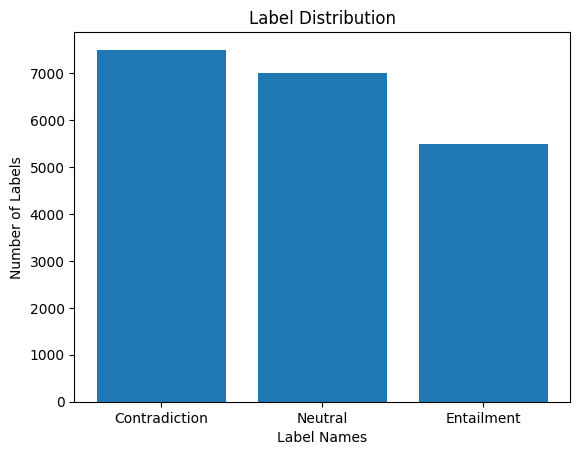

In [12]:
import matplotlib.pyplot as plt
categories = ['Contradiction','Neutral','Entailment']
value = [values[0], values[1], values[2]]
# Create a bar chart
plt.bar(categories, value)

# Customize the chart
plt.xlabel('Label Names')      # Label for the x-axis
plt.ylabel('Number of Labels')          # Label for the y-axis
plt.title('Label Distribution') # Title for the chart

# Display the chart
plt.show()


# Tokenization of the training and the validation datasets
## Training Dataset:

In [13]:
from transformers import RobertaTokenizer

# Load the RoBERTa tokenizer.
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading RoBERTa tokenizer...


Example Tokenization on a sentence in the training dataset

In [14]:
# Print the original sentence.
print('Original: ', sentences1[0])

# Print the sentence split into tokens.
print('Tokenized sentence1: ', tokenizer.tokenize(sentences1[0]))
print('Tokenized sentence2: ', tokenizer.tokenize(sentences2[0]))

# Print the sentence mapped to token ids.
print('Token IDs for sentence 1: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences1[0])))
print('Token IDs for sentence 2: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences2[0])))

Original:  A person on a horse jumps over a broken down airplane.
Tokenized sentence1:  ['A', 'Ġperson', 'Ġon', 'Ġa', 'Ġhorse', 'Ġjumps', 'Ġover', 'Ġa', 'Ġbroken', 'Ġdown', 'Ġairplane', '.']
Tokenized sentence2:  ['A', 'Ġperson', 'Ġis', 'Ġoutdoors', ',', 'Ġon', 'Ġa', 'Ġhorse', '.']
Token IDs for sentence 1:  [250, 621, 15, 10, 5253, 13855, 81, 10, 3187, 159, 16847, 4]
Token IDs for sentence 2:  [250, 621, 16, 13384, 6, 15, 10, 5253, 4]


In [15]:
max_len = 0

# For every sentence in sentence1...
for i in range(0,len(sentences1)):

    # Tokenize the text.
    input_ids = tokenizer.encode(sentences1[i], sentences2[i], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  95


In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(0,len(sentences1)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text=sentences1[i],
                        text_pair= sentences2[i],  # Sentences to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attn. masks.
                        truncation=True,  # Truncate if the total length exceeds max_length
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
train_input_ids = torch.cat(input_ids, dim=0)
train_attention_masks = torch.cat(attention_masks, dim=0)

# Converting labels into numerical values
int_labels = []
for i in range(len(labels)):
    if labels[i]=='entailment':
      int_labels.append(1)
    elif labels[i]=='contradiction':
      int_labels.append(0)
    else:
      int_labels.append(2) # For neutral

train_labels = torch.tensor(int_labels)

# Print sentence 1 and 2, now as a list of IDs.
print('Original: ', sentences1[0])
print('Original2: ', sentences2[0])
print('Token IDs:', train_input_ids[0])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  A person on a horse jumps over a broken down airplane.
Original2:  A person is outdoors, on a horse.
Token IDs: tensor([    0,   250,   621,    15,    10,  5253, 13855,    81,    10,  3187,
          159, 16847,     4,     2,     2,   250,   621,    16, 13384,     6,
           15,    10,  5253,     4,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     

In [17]:
print(len(train_labels),len(train_input_ids), len(train_attention_masks))

20000 20000 20000


## ValidationDataset:
Doing the encoding for the validation set

In [18]:
# Load the validation dataset into pandas dataframe.
vdf = pd.read_csv("/kaggle/input/snli-datasets/snli_dev.tsv", sep='\t', header=0)
vdf = vdf[['gold_label','sentence1','sentence2']]
# Report the number of sentences.
print('Number of validation sentences: {:,}\n'.format(vdf.shape[0]))

# Display 10 random rows from the data.
print(vdf.head(10))

Number of validation sentences: 10,000

      gold_label                                          sentence1  \
0        neutral  Two women are embracing while holding to go pa...   
1     entailment  Two women are embracing while holding to go pa...   
2  contradiction  Two women are embracing while holding to go pa...   
3     entailment  Two young children in blue jerseys, one with t...   
4        neutral  Two young children in blue jerseys, one with t...   
5  contradiction  Two young children in blue jerseys, one with t...   
6  contradiction  A man selling donuts to a customer during a wo...   
7        neutral  A man selling donuts to a customer during a wo...   
8     entailment  A man selling donuts to a customer during a wo...   
9     entailment  Two young boys of opposing teams play football...   

                                           sentence2  
0  The sisters are hugging goodbye while holding ...  
1                    Two woman are holding packages.  
2            

Drop the rows with '-' as gold_labels

In [19]:
print(vdf['gold_label'].value_counts())

gold_label
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: count, dtype: int64


###Data Cleaning:
Removing rows of the Dataset which have '-' as the label

In [20]:
tobedeletedDF = vdf[vdf['gold_label'] == '-']
print(tobedeletedDF)
vdf = vdf[vdf['gold_label'] != '-']

     gold_label                                          sentence1  \
66            -  The middle eastern woman wearing the pink head...   
201           -  A white-haired man with a mustache and glasses...   
221           -  A group of people sit on benches at a park out...   
283           -  Two male police officers on patrol, wearing th...   
332           -  A restaurant front line, with a warmer in the ...   
...         ...                                                ...   
9622          -  Several African American children posing for t...   
9849          -  A curly-haired redhead is wearing a blue check...   
9851          -  A small group of adults and children stand on ...   
9859          -  A woman looking through what appears to be a t...   
9995          -  A small girl wearing a pink jacket is riding o...   

                                              sentence2  
66                      Two women are walking together.  
201                           There are peo

Checking the revised number of rows in the validation dataset

In [21]:
print(vdf.shape)

(9842, 3)


In [ ]:
# Get the lists of sentences and their labels.
sentences1 = vdf['sentence1'].values.tolist()
sentences2 = vdf['sentence2'].values.tolist()
labels = vdf['gold_label'].values.tolist()
# print(sentences1)
# print(sentences2)
print(labels)

In [23]:
# Print the original sentence.
print('Original: ', sentences1[0])

# Print the sentence split into tokens.
print('Tokenized sentence1: ', tokenizer.tokenize(sentences1[0]))
print('Tokenized sentence2: ', tokenizer.tokenize(sentences2[0]))

# Print the sentence mapped to token ids.
print('Token IDs for sentence 1: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences1[0])))
print('Token IDs for sentence 2: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences2[0])))

Original:  Two women are embracing while holding to go packages.
Tokenized sentence1:  ['Two', 'Ġwomen', 'Ġare', 'Ġembracing', 'Ġwhile', 'Ġholding', 'Ġto', 'Ġgo', 'Ġpackages', '.']
Tokenized sentence2:  ['The', 'Ġsisters', 'Ġare', 'Ġhugging', 'Ġgoodbye', 'Ġwhile', 'Ġholding', 'Ġto', 'Ġgo', 'Ġpackages', 'Ġafter', 'Ġjust', 'Ġeating', 'Ġlunch', '.']
Token IDs for sentence 1:  [9058, 390, 32, 16105, 150, 1826, 7, 213, 8368, 4]
Token IDs for sentence 2:  [133, 7502, 32, 31164, 15364, 150, 1826, 7, 213, 8368, 71, 95, 4441, 4592, 4]


In [24]:
max_len = 0

# For every sentence in sentence1...
for i in range(0,len(sentences1)):

    # Tokenize the text.
    input_ids = tokenizer.encode(sentences1[i], sentences2[i], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  118


In [25]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(0,len(sentences1)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text=sentences1[i],
                        text_pair= sentences2[i],  # Sentences to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,
                        pad_to_max_length = True,   # Pad & truncate all sentences
                        return_attention_mask = True, # Construct attn. masks.
                        truncation=True,  # Truncate if the total length exceeds max_length
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
validation_input_ids = torch.cat(input_ids, dim=0)
validation_attention_masks = torch.cat(attention_masks, dim=0)

# Converting labels into numerical values
int_labels = []
for i in range(len(labels)):
    if labels[i]=='entailment':
      int_labels.append(1)
    elif labels[i]=='contradiction':
      int_labels.append(0)
    else:
      int_labels.append(2) # For neutral

validation_labels = torch.tensor(int_labels)

# Print sentence 1 and 2, now as a list of IDs.
print('Original: ', sentences1[0])
print('Original2: ', sentences2[0])
print('Token IDs:', input_ids[0])

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Two women are embracing while holding to go packages.
Original2:  The sisters are hugging goodbye while holding to go packages after just eating lunch.
Token IDs: tensor([[    0,  9058,   390,    32, 16105,   150,  1826,     7,   213,  8368,
             4,     2,     2,   133,  7502,    32, 31164, 15364,   150,  1826,
             7,   213,  8368,    71,    95,  4441,  4592,     4,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,

## 3.4. Training & Validation Dataloading

In [26]:
from torch.utils.data import TensorDataset

# Combine the training and validation inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
validation_dataset = TensorDataset(validation_input_ids, validation_attention_masks, validation_labels)

# Calculate the number of samples to include in each set.
train_size = len(train_dataset)
val_size = len(validation_dataset)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

20,000 training samples
9,842 validation samples


In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Train Our NLI task

In [28]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

# Load RobertaForSequenceClassification, the pretrained RoBERTa model with a single
# linear classification layer on top.
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    num_labels = 3, # The number of output labels--3 for multiple classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

The embedding layer.
The first of the twelve transformers.
The output layer.

In [29]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

# Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.


>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [30]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Training Loop

In [32]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`

In [33]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Start the Training!!!

In [34]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments.
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:27.
  Batch    80  of    625.    Elapsed: 0:00:50.
  Batch   120  of    625.    Elapsed: 0:01:14.
  Batch   160  of    625.    Elapsed: 0:01:39.
  Batch   200  of    625.    Elapsed: 0:02:04.
  Batch   240  of    625.    Elapsed: 0:02:29.
  Batch   280  of    625.    Elapsed: 0:02:53.
  Batch   320  of    625.    Elapsed: 0:03:18.
  Batch   360  of    625.    Elapsed: 0:03:43.
  Batch   400  of    625.    Elapsed: 0:04:08.
  Batch   440  of    625.    Elapsed: 0:04:33.
  Batch   480  of    625.    Elapsed: 0:04:58.
  Batch   520  of    625.    Elapsed: 0:05:23.
  Batch   560  of    625.    Elapsed: 0:05:48.
  Batch   600  of    625.    Elapsed: 0:06:13.

  Average training loss: 0.64
  Training epoch took: 0:06:28

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.38
  Validation took: 0:01:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    625.    Elapsed: 0:00:25.
  Batch  

In [35]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.64,0.38,0.86,0:06:28,0:01:00
2,0.39,0.36,0.88,0:06:30,0:01:00
3,0.29,0.37,0.88,0:06:29,0:01:00
4,0.22,0.40,0.88,0:06:29,0:01:00


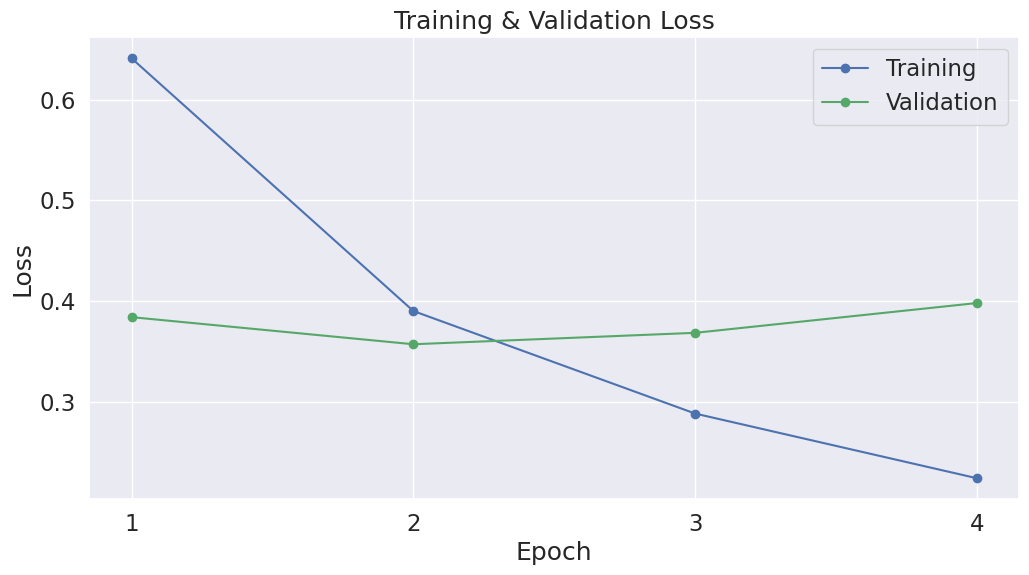

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance On Test Set

### Test Data Preparation

In [37]:
import pandas as pd
# Load the test dataset into pandas dataframe.
tdf = pd.read_csv("/kaggle/input/snli-datasets/snli_test.tsv", sep='\t', header=0)
tdf = tdf[['gold_label','sentence1','sentence2']]

# Display 10 random rows from the data.
# print(tdf.head(10))

# Remove the gold labels with '-' values
tobedeletedDF = tdf[tdf['gold_label'] == '-']
print('No. of rows to be deleted: ',len(tobedeletedDF))
tdf = tdf[tdf['gold_label'] != '-']

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(tdf.shape[0]))

# Create sentence and label lists
sentences1 = tdf['sentence1'].values.tolist()
sentences2 = tdf['sentence2'].values.tolist()
labels = tdf['gold_label'].values.tolist()
print(tdf['gold_label'])

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(0,len(sentences1)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sentences1[i],                      # Sentence to encode.
                        sentences2[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        truncation=True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(input_ids, dim=0)
test_attention_masks = torch.cat(attention_masks, dim=0)

# Converting labels into numerical values
int_labels = []
for i in range(len(labels)):
    if labels[i]=='entailment':
      int_labels.append(1)
    elif labels[i]=='contradiction':
      int_labels.append(0)
    else:
      int_labels.append(2) # For neutral

test_labels = torch.tensor(int_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

No. of rows to be deleted:  176
Number of test sentences: 9,824

0             neutral
1          entailment
2       contradiction
3             neutral
4          entailment
            ...      
9995    contradiction
9996       entailment
9997    contradiction
9998       entailment
9999          neutral
Name: gold_label, Length: 9824, dtype: object


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Evaluate on Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [38]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

print('    DONE.')

Predicting labels for 9,824 test sentences...
    DONE.


In [39]:
# Get first 10 values of predictions and true labels
print(predictions[0:10])
print(true_labels[0:10]) 

[0, 1, 0, 2, 2, 0, 1, 2, 0, 2]
[2, 1, 0, 2, 1, 0, 1, 2, 0, 2]


In [40]:
from sklearn.metrics import classification_report

result_report= classification_report(true_labels, predictions, digits=3, output_dict=True)
print(result_report)

{'0': {'precision': 0.8951686417502279, 'recall': 0.9101019462465245, 'f1-score': 0.9025735294117647, 'support': 3237}, '1': {'precision': 0.9077490774907749, 'recall': 0.8764845605700713, 'f1-score': 0.8918429003021148, 'support': 3368}, '2': {'precision': 0.8360256019506248, 'recall': 0.8521279900590245, 'f1-score': 0.844, 'support': 3219}, 'accuracy': 0.8795806188925082, 'macro avg': {'precision': 0.8796477737305426, 'recall': 0.8795714989585401, 'f1-score': 0.8794721432379599, 'support': 9824}, 'weighted avg': {'precision': 0.8801024225380168, 'recall': 0.8795806188925082, 'f1-score': 0.8797020972031153, 'support': 9824}}


# Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [41]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

The following functions will load the model back from disk.

In [42]:
# Load a trained model and vocabulary that you have fine-tuned
model = RobertaForSequenceClassification.from_pretrained(output_dir)
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             